In [1]:
'''
Considerations
-train neural net within ages of 2-6 Gyrs: we know M67 has an age of about 4Gyrs, so there is no point to training it outside this range
-We want to have a working neural net that works to a precision of 0.005 dex (0.5% precision), though we should make a determination of how accurate we want it to be. 
-Most logical loss function is MAE (mean absolute error), although the Median Absolute Error is smaller. We probably want to train using the Mean Absolute Error and then evaluate using the Median Absolute Error.
-To determine an adequate guess than the number of epochs to train for we can take a small portion of the grid (e.g. say only where the metallicity is solar and take a few masses) train the neural net till it reaches the desired precision, suggested architecture (3,8,8,2) = (inputs,nodes, hidden layers, outputs).
-Sensible number of epochs = 50,000
-We want to try an architecture which is the smallest we can get away with such that its faster (start with small architecture and work up).
'''
#import seaborn as sns
#import pandas as pd
#import pickle
import dill
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import yaml
#data = np.genfromtxt('grid_0_0.csv',delimiter=",",skip_header=1)
#data = np.genfromtxt('grid_mid_0_0.csv',delimiter=",",skip_header=1)


'''
small grid:
[0]=row
[1]=model_number
[2]=star_mass
[3]=star_age
[4]=star_feh
[5]=star_MLT
[6]=star_fov
[7]=effective_T
[8]=luminosity
[9]=radius
[10]=log_g
[11]=surface_h1
[12]=surface_he4
[13]=center_h1
[14]=center_he4
[15]=log_center_T
[16]=log_center_Rho
[17]=he_core_mass
[18]=delta_nu
[19]=delta_Pg
[20]=nu_max
[21]=nu_0_10
[22]=nu_0_11
[23]=nu_0_12
[24]=nu_0_13
[25]=nu_0_14
[26]=nu_0_15

mid grid:
[0]=row
[1]=star_mass
[2]=star_age
[3]=initial_Yinit
[4]=initial_feh
[5]=initial_MLT
[6]=initial_fov
[7]=effective_T
[8]=luminosity
[9]=delta_nu

'''


'\nsmall grid:\n[0]=row\n[1]=model_number\n[2]=star_mass\n[3]=star_age\n[4]=star_feh\n[5]=star_MLT\n[6]=star_fov\n[7]=effective_T\n[8]=luminosity\n[9]=radius\n[10]=log_g\n[11]=surface_h1\n[12]=surface_he4\n[13]=center_h1\n[14]=center_he4\n[15]=log_center_T\n[16]=log_center_Rho\n[17]=he_core_mass\n[18]=delta_nu\n[19]=delta_Pg\n[20]=nu_max\n[21]=nu_0_10\n[22]=nu_0_11\n[23]=nu_0_12\n[24]=nu_0_13\n[25]=nu_0_14\n[26]=nu_0_15\n\nmid grid:\n[0]=row\n[1]=star_mass\n[2]=star_age\n[3]=initial_Yinit\n[4]=initial_feh\n[5]=initial_MLT\n[6]=initial_fov\n[7]=effective_T\n[8]=luminosity\n[9]=delta_nu\n\n'

In [2]:
'''
required columns:
1. track row number: tends to be column 0
2. input data columns
3. output data columns

required inputs:
variable limit ranges
input_data=np.vstack((data[[track_indeces],2],data[[track_indeces],3]))
output_data=np.vstack(([data[[track_indeces],7],data[[track_indeces],8]]))
new=True
epochs=100000
validation_fraction=0.1
nodes=100
Hidden_layers=6
regularization=False
learning_rate=0.001
beta_1=0.9995
beta_2=0.999
epsilon=1e-9
'''     
'''
TODO/remember:
- add function to run pretrained NN?????
- RunMode: 0 = with graphs, 1 = without graphs 
- i want the new=True variable to be the only thing directly passed by the user except the grid file name
- limit no. tracks printed when printing diagrams
-check the no. input and output columns requested and raise error if either of them are 0
- get dex
- fix text
- think about enabling it so you can change parameters part way thorugh training. 
- save weights to history_dict
- add text to colourbars
- add shuffle permutation to history_dict
- Reminder: when adding additional output parameters remember to 1. add a graph row for them 2. add a condition to calculate their dex
'''
#--- user input variables
#grid_file = 'grid_0_0'
pref_file = 'preferences'
grid_file = 'grid_mid_0_0'
model_name = 'NNv2.h5'
new = True
##################

#---variables updated by preferences file
#pref = [] #'grid_pref','RunMode':0,'NN_pref': {'epochs','validation_fraction','nodes','Hidden_layers','regularization','learning_rate','beta_1','beta_2','epsilon'}
#data = [] # 'inputs':{},'outputs':{},'track':array
#track_indeces = []
#input_data=np.vstack((data[[track_indeces],2],data[[track_indeces],3]))
#input_data = []
#output_data=np.vstack(([data[[track_indeces],7],data[[track_indeces],8]]))
#output_data = []
##################

def load_file_and_preferences(file,pref_file):
    '''
    loads the given grid
    returns data, grid preferences (if available) and neural net preferences
    '''
    try:
        data = np.genfromtxt(file+'.csv',delimiter=",",skip_header=1)
    except FileNotFoundError as e:
        data = None
        
    try:
        with open(pref_file+'.txt') as f:
            pref = yaml.load(f, Loader=yaml.FullLoader)
        #pref = pickle.load( open('preferences.txt', "rb" ) )
        #with open('preferences.txt', 'rb') as in_file:
        #    pref = dill.load(in_file)
        try:
            preferences = {'grid_pref':pref['Grid'][file],'NN_pref':pref['NeuralNet'],'RunMode':pref['RunMode']}
            for i in preferences['NN_pref']:
                if i == 'epochs' or i == 'nodes' or i == 'Hidden_layers':
                    pass
                else:
                    try:
                        preferences['NN_pref'][i] = float(preferences['NN_pref'][i])
                    except TypeError:
                        pass
        except KeyError:
            print("No grid preferences found: please see \'preferences.txt\'")
            preferences = None

    except FileNotFoundError as e:
        preferences = None
        
    return data,preferences

def create_data_dict(data,pref):
    input_cols = set().union(*(d.keys() for d in [pref['grid_pref']['inputs']]))
    output_cols = set().union(*(d.keys() for d in [pref['grid_pref']['outputs']]))
    data_dict = {'inputs':{},'outputs':{},'track':data[:,0]}
    for i in input_cols:
            data_dict['inputs'][i] = data[:,pref['grid_pref']['inputs'][i]['col']]
    for i in output_cols:
            data_dict['outputs'][i] = data[:,pref['grid_pref']['outputs'][i]['col']]
    return data_dict,pref

def find_tracks(data): #splits data into the individual stellar evalution tracks
    track_starts = np.where(data['track'] == 0)[0] #finds every occurance of the first row of a evolutionary track
    track_ends = np.append(track_starts[1:]-1,len(data['track'])-1) #looks for the row elemnt before each first row of each evolutionary track (except for the 0th row) to find the end of the previous track and then the last row of the data is appended to get the end of the last track.
    tracks = list(zip(track_starts,track_ends)) #combines the start and end row element of each track
    return tracks #each element of the list is track[i][0]=start row of ith track, track[i][1]= end row ith track.

def parameter_limits(pref):
    input_cols = set().union(*(d.keys() for d in [pref['grid_pref']['inputs']]))
    for param in input_cols:
        if pref['grid_pref']['inputs'][param]['lim'] != 'None':
            return True
    return False

def find_lim_tracks(lim_data_indeces):
    tracks = []
    track_start = lim_data_indeces[0]
    for i in range(len(lim_data_indeces)-1):
        if lim_data_indeces[i+1] != lim_data_indeces[i]+1:
            tracks.append([track_start,lim_data_indeces[i]])
            track_start = lim_data_indeces[i+1]
    tracks.append([track_start,lim_data_indeces[-1]])
    return tracks
        

def limit_parameter_range(data,pref): #allows the ability to optimize computation by training only on a limited range on multiple variables to just that is useful for the current scientific enquiry.
    tracks = find_tracks(data=data)
    input_cols = set().union(*(d.keys() for d in [pref['grid_pref']['inputs']]))

    list_limited_tracks_indeces=[]
    for param in input_cols:
        limited_tracks = []
        limited_tracks_indeces = []
        if pref['grid_pref']['inputs'][param]['lim'] != 'None':
            for i in range(len(tracks)):
                track = data['inputs'][param][tracks[i][0]:tracks[i][1]+1]
                lb = (np.abs(track - pref['grid_pref']['inputs'][param]['lim'][0])).argmin() + tracks[i][0]
                ub = (np.abs(track - pref['grid_pref']['inputs'][param]['lim'][1])).argmin()+ tracks[i][0]
                if data['inputs'][param][ub] > pref['grid_pref']['inputs'][param]['lim'][0]: #makes sure stars whose highest value of this parameter is still below the lower bounds aren't included.
                    limited_tracks.append([lb,ub])
            for i in range(len(limited_tracks)):
                limited_tracks_indeces+=list(range(limited_tracks[i][0],limited_tracks[i][1]+1))
            list_limited_tracks_indeces.append(limited_tracks_indeces)
    lim_data_indeces = sorted(list(set(list_limited_tracks_indeces[0]).intersection(*list_limited_tracks_indeces)))
    if len(lim_data_indeces) == 0:
        return None,None
    else:
        tracks = find_lim_tracks(lim_data_indeces=lim_data_indeces)
        return tracks, lim_data_indeces
 
def gen_parameter_tracks(data,tracks,param,pref):
    if param in set().union(*(d.keys() for d in [pref['grid_pref']['outputs']])):
        x = data['outputs'][param][tracks[0][0]:tracks[0][1]+1]
        for i in range(1,len(tracks)):
            x = np.append(x,data['outputs'][param][tracks[i][0]:tracks[i][1]+1])
    
    elif param in set().union(*(d.keys() for d in [pref['grid_pref']['inputs']])):
        x = data['inputs'][param][tracks[0][0]:tracks[0][1]+1]
        for i in range(1,len(tracks)):
            x = np.append(x,data['inputs'][param][tracks[i][0]:tracks[i][1]+1])
    else:
        x = None
    return x

def HRplot(tracks,data):
    temp = gen_parameter_tracks(data=data,tracks=tracks,param='T')
    lum = gen_parameter_tracks(data=data,tracks=tracks,param='L')
    mass = gen_parameter_tracks(data=data,tracks=tracks,param='M')
    fig, ax=plt.subplots(1,1,figsize=[10,10])
    s1=ax.scatter(np.log(temp),np.log(lum),s=5,c=mass,cmap='viridis')
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel(r'$log(L/L_{\odot})$')
    ax.set_xlabel(r'$log T_{eff}$')
    fig.colorbar(s1)
    plt.show() 

def dex_calc(d,m):
    return np.mean(abs((d-m)/d))
    
    
def plotHist(training,model,input_data,tracks,data,pref,file,history_dict):
    print('working')
    fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))
    #ax = ax.flatten()
    print('working1.5')
    epoch_list = list(range(history_dict['epoch']))
    output_order = sorted(list(set().union(*(d.keys() for d in [data['outputs']]))))
    input_data, output_data = format_input_ouput(data=data,track_indeces=track_indeces,pref=pref,shuffle=False)
    print('working1.9')
    prediction = model.predict(input_data.T,verbose=2).T
    print('working2')
    dex = {}
    for i in range(len(output_order)):
        if output_order[i] == 'L':
            L_i = i
            #print(np.shape(output_data[:,L_i]))
            dex['L'] = 'L: '+str(dex_calc(d=output_data[L_i,:],m=prediction[L_i]))
        elif output_order[i] == 'T':
            T_i = i
            dex['T'] = 'T: '+str(dex_calc(d=output_data[T_i,:],m=prediction[T_i]))
        elif output_order[i] == 'del_nu':
            del_nu_i = i
            dex['del_nu'] = 'del_nu: '+str(dex_calc(d=output_data[T_i,:],m=prediction[del_nu_i]))
    dex_list = []
    dex_ordered = sorted(list(set().union(*(d.keys() for d in [dex]))))
    for i in dex_ordered:
        dex_list.append(dex[i])
    dex_list = dex_list + (['']*(5-len(dex_list)))
    
    collabel=("Grid: "+file, "Optimizer","Dex")
    row_vals = [['Nodes per layer: '+str(pref['NN_pref']['nodes']),'Initial Learning Rate: '+str(pref['NN_pref']['learning_rate']),dex_list[0]],
                ['Epochs: '+str(history_dict['epoch']), 'Beta 1: '+str(pref['NN_pref']['beta_1']),dex_list[1]],
                ['Hidden Layers: '+str(pref['NN_pref']['Hidden_layers']), 'Beta 2: '+str(pref['NN_pref']['beta_2']),dex_list[2]],
                ['Validation fraction: '+str(pref['NN_pref']['validation_fraction']),'Epsilon: '+str(pref['NN_pref']['epsilon']),dex_list[3]],
                ['Regularization: '+str(pref['NN_pref']['regularization']),'',dex_list[4]]]
    ax[0,0].axis('tight')
    ax[0,0].axis('off')
    table = ax[0,0].table(cellText=row_vals,colLabels=collabel,loc='center')
    table.scale(1,2)
    table.set_fontsize(18)
    cells = table.properties()["celld"]
    for i in range(len(row_vals)+1):
            for j in range(len(row_vals[0])):
                    cells[i, j]._loc = 'left'  
    

    ax[0,1].plot(epoch_list,history_dict['mae'],'b',label='mae')
    ax[0,1].plot(epoch_list,history_dict['val_mae'],'r',label='valmae')
    #ax[1].plot(epoch_list,history_dict['mse'],'b:',label='mse')
    #ax[1].plot(epoch_list,history_dict['val_mse'],'r:',label='valmse')
    ax[0,1].set_yscale('log')
    ax[0,1].set_xlabel('epoch')
    ax[0,1].set_ylabel('metric')
    ax[0,1].legend()
    print('working4')
    temp = gen_parameter_tracks(data=data,tracks=tracks,param='T')
    lum = gen_parameter_tracks(data=data,tracks=tracks,param='L')
    mass = gen_parameter_tracks(data=data,tracks=tracks,param='M')
    ax[1,0].scatter(np.log10(temp),np.log10(lum),s=5,c=mass,cmap='viridis')
    ax[1,0].invert_xaxis()
    ax[1,0].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1,0].set_xlabel(r'$log T_{eff}$')
    ax[1,0].set_title('HR diagram from data grid')

    
    s2 = ax[1,1].scatter(prediction[T_i],prediction[L_i],s=5,c=mass,cmap='viridis')
    ax[1,1].invert_xaxis()
    ax[1,1].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1,1].set_xlabel(r'$log T_{eff}$')
    ax[1,1].set_title('HR diagram of neural net predicted values')
    #fig.colorbar(s2)
    print('working5')
    #'''
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, ax[1,1].get_position().y0, 0.025, ax[1,1].get_position().height])
    cbar_ax.text(0.5,1.03,r'$M/M_{\odot}$',fontsize=14,horizontalalignment='center',transform=cbar_ax.transAxes)
    fig.colorbar(s2, cax=cbar_ax)
    #'''
    print('working6')
    plt.show()
    print('working7')

def shuffle_data(input_data,output_data):
    p = np.random.permutation(len(input_data[0,:]))
    for i in range(len(input_data)):
        input_data[i,:] = input_data[i,:][p]
    for i in range(len(output_data)):
        output_data[i,:] = output_data[i,:][p]
    
    return input_data,output_data

def format_input_ouput(data,track_indeces,pref,shuffle):
    input_list = sorted(list(set().union(*(d.keys() for d in [data['inputs']]))))
    output_list = sorted(list(set().union(*(d.keys() for d in [data['outputs']]))))
    input_data=np.vstack(([data['inputs'][i][track_indeces] for i in sorted(list(set().union(*(d.keys() for d in [data['inputs']]))))]))

    
    for i in range(len(input_data)):
        if pref['grid_pref']['inputs'][input_list[i]]['log'] == True:
            input_data[i,:] = np.log10(input_data[i,:])
    
    output_data = np.vstack(([data['outputs'][i][track_indeces] for i in sorted(list(set().union(*(d.keys() for d in [data['outputs']]))))]))
    for i in range(len(output_data)):
        if pref['grid_pref']['outputs'][output_list[i]]['log'] == True:
            output_data[i,:] = np.log10(output_data[i,:])
    if shuffle == True:
        input_data,output_data = shuffle_data(input_data=input_data,output_data=output_data)   
    return input_data, output_data

def save_history(history_dict,training,model,model_name):
    if history_dict == None:
        history_dict = {
                       "mae":training.history['mae'],
                       "mse":training.history['mse'],
                       "val_mae":training.history['val_mae'],
                       "val_mse":training.history['val_mse'],
                       "epoch":training.params['epochs'],
                       "weights":np.array(model.get_weights())}
        #print(history_dict)
    
    else:
        history_dict = {
                       'mae':np.concatenate((history_dict['mae'],training.history['mae'])),
                       'mse':np.concatenate((history_dict['mse'],training.history['mse'])),
                       'val_mae':np.concatenate((history_dict['val_mae'],training.history['val_mae'])),
                       'val_mse':np.concatenate((history_dict['val_mse'],training.history['val_mse'])),
                       'epoch':history_dict['epoch']+training.params['epochs'],
                        'weights':np.array(model.get_weights())}

    #with open(model_name[:-3]+'_history.txt', 'w') as out_file:
    #    yaml.dump(history_dict, out_file)
    #pickle.dump(history_dict, open(model_name[:-3]+'_history.txt', "wb" ) )
    with open(model_name[:-3]+'_history', 'wb') as out_file: 
        dill.dump(history_dict, out_file)
    return history_dict


def NN_setup(input_data,output_data,pref,model_name,new): #inputs = list where each element is all the desired data for a varaible i.e. data[:,2][track_indeces]
    #new = True #train new neural net
    if new == True:
        inputs=keras.Input(shape=(len(input_data),))
        xx=keras.layers.Dense(pref['NN_pref']['nodes'],activation='relu')(inputs)
        for i in range(pref['NN_pref']['Hidden_layers']-1):
            if pref['NN_pref']['regularization'] != False:
                xx = layers.Dense(pref['NN_pref']['nodes'], activation='relu',kernel_regularizer=keras.regularizers.l2(pref['NN_pref']['regularization']))(xx)
            else:
                xx = layers.Dense(pref['NN_pref']['nodes'], activation='relu')(xx)
        outputs=keras.layers.Dense(len(output_data),activation='linear')(xx)

        model = keras.Model(inputs=inputs, outputs=outputs)
        opt = keras.optimizers.Nadam(learning_rate=pref['NN_pref']['learning_rate'], beta_1=pref['NN_pref']['beta_1'], beta_2=pref['NN_pref']['beta_2'], epsilon=pref['NN_pref']['epsilon'])
        model.compile(optimizer=opt,
                  loss='MAE',
                  metrics=['mae', 'mse'])
        history_dict = None
    else:
        model = keras.models.load_model(model_name)
        #history_dict = None
        #'''
        #with open(model_name[:-3]+'_history.txt') as in_file:
        #    history_dict = yaml.load(in_file, Loader=yaml.FullLoader)
        #history_dict = pickle.load( open( model_name[:-3]+'_history.txt', "rb" ) )
        with open(model_name[:-3]+'_history', 'rb') as in_file:
            history_dict = dill.load(in_file)
        #'''
    return model, history_dict

def train_NN(data,pref,track_indeces,tracks,model_name,file,new):
    input_data, output_data = format_input_ouput(data=data,track_indeces=track_indeces,pref=pref,shuffle=True)
    model, history_dict = NN_setup(input_data,output_data,pref,model_name=model_name,new=new)
    training = model.fit(input_data.T, output_data.T,
        epochs=pref['NN_pref']['epochs'],
        batch_size=len(input_data[0]),
        validation_split=pref['NN_pref']['validation_fraction'],
        verbose=0)
    
    model.save(model_name)
    history_dict = save_history(history_dict=history_dict,training=training,model=model,model_name=model_name)
    '''
    if pref['RunMode'] == 0:
        print('Training Finished at: '+str(datetime.now()))
        model.summary()
        plotHist(training=training,model=model,input_data=input_data.T,tracks=tracks,data=data,pref=pref,file=file,history_dict=history_dict)
    '''
    
    
    return training,model

def plot2(model_name,file):
    fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(10,20))
    data,pref = load_file_and_preferences(file=file)
    data,pref = create_data_dict(data=data,pref=pref)
    mass = gen_parameter_tracks(data=data,tracks=tracks,param='M')
    
    model = keras.models.load_model(model_name)
    output_order = sorted(list(set().union(*(d.keys() for d in [data['outputs']]))))
    input_data, output_data = format_input_ouput(data=data,track_indeces=track_indeces,pref=pref,shuffle=False)
    prediction = model.predict(input_data.T,verbose=2).T
    for i in range(len(output_order)):
        if output_order[i] == 'L':
            L_i = i
        elif output_order[i] == 'T':
            T_i = i
    s2 = ax.scatter(prediction[T_i],prediction[L_i],s=5,c=mass,cmap='viridis')
    ax.invert_xaxis()
    ax.set_ylabel(r'$log(L/L_{\odot})$')
    ax.set_xlabel(r'$log T_{eff}$')
    fig.colorbar(s2)   
    plt.show()

def post_training_plot(model_name,file,pref_file):
    data,pref = load_file_and_preferences(file=file,pref_file=pref_file)
    model = keras.models.load_model(model_name)
    with open(model_name[:-3]+'_history', 'rb') as in_file:
            history_dict = dill.load(in_file)
    if data.any() != None and pref != None:
        data,pref = create_data_dict(data=data,pref=pref)
        if parameter_limits(pref=pref) == True:
            tracks,track_indeces = limit_parameter_range(data=data,pref=pref)
            if tracks != None and track_indeces != None:
                pass
            else:
                print('Parameter limits not compatible.')
        else:
            tracks = find_tracks(data=data)
            track_indeces = np.arange(len(data['track']))
    
    
    fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(20,20))

    epoch_list = list(range(history_dict['epoch']))
    output_order = sorted(list(set().union(*(d.keys() for d in [data['outputs']]))))
    input_data, output_data = format_input_ouput(data=data,track_indeces=track_indeces,pref=pref,shuffle=False)

    prediction = model.predict(input_data.T,verbose=2).T

    dex = {}
    for i in range(len(output_order)):
        if output_order[i] == 'L':
            L_i = i
            #print(np.shape(output_data[:,L_i]))
            dex['L'] = 'L: '+str(dex_calc(d=output_data[L_i,:],m=prediction[L_i]))
        elif output_order[i] == 'T':
            T_i = i
            dex['T'] = 'T: '+str(dex_calc(d=output_data[T_i,:],m=prediction[T_i]))
        elif output_order[i] == 'del_nu':
            del_nu_i = i
            dex['del_nu'] = 'del_nu: '+str(dex_calc(d=output_data[T_i,:],m=prediction[del_nu_i]))
    dex_list = []
    dex_ordered = sorted(list(set().union(*(d.keys() for d in [dex]))))
    for i in dex_ordered:
        dex_list.append(dex[i])
    dex_list = dex_list + (['']*(5-len(dex_list)))
    
    collabel=("Grid: "+file, "Optimizer","Dex")
    row_vals = [['Nodes per layer: '+str(pref['NN_pref']['nodes']),'Initial Learning Rate: '+str(pref['NN_pref']['learning_rate']),dex_list[0]],
                ['Epochs: '+str(history_dict['epoch']), 'Beta 1: '+str(pref['NN_pref']['beta_1']),dex_list[1]],
                ['Hidden Layers: '+str(pref['NN_pref']['Hidden_layers']), 'Beta 2: '+str(pref['NN_pref']['beta_2']),dex_list[2]],
                ['Validation fraction: '+str(pref['NN_pref']['validation_fraction']),'Epsilon: '+str(pref['NN_pref']['epsilon']),dex_list[3]],
                ['Regularization: '+str(pref['NN_pref']['regularization']),'',dex_list[4]]]
    ax[0,0].axis('tight')
    ax[0,0].axis('off')
    table = ax[0,0].table(cellText=row_vals,colLabels=collabel,loc='center')
    table.scale(1,2)
    table.set_fontsize(18)
    cells = table.properties()["celld"]
    for i in range(len(row_vals)+1):
            for j in range(len(row_vals[0])):
                    cells[i, j]._loc = 'left'  
    
    ax[0,1].plot(epoch_list,history_dict['mae'],'b',label='mae')
    ax[0,1].plot(epoch_list,history_dict['val_mae'],'r',label='valmae')
    #ax[1].plot(epoch_list,history_dict['mse'],'b:',label='mse')
    #ax[1].plot(epoch_list,history_dict['val_mse'],'r:',label='valmse')
    ax[0,1].set_yscale('log')
    ax[0,1].set_xlabel('epoch')
    ax[0,1].set_ylabel('metric')
    ax[0,1].legend()

    temp = gen_parameter_tracks(data=data,tracks=tracks,param='T',pref=pref)
    lum = gen_parameter_tracks(data=data,tracks=tracks,param='L',pref=pref)
    mass = gen_parameter_tracks(data=data,tracks=tracks,param='M',pref=pref)
    ax[1,0].scatter(np.log10(temp),np.log10(lum),s=5,c=mass,cmap='viridis')
    ax[1,0].invert_xaxis()
    ax[1,0].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1,0].set_xlabel(r'$log T_{eff}$')
    ax[1,0].set_title('HR diagram from data grid')

    
    s2 = ax[1,1].scatter(prediction[T_i],prediction[L_i],s=5,c=mass,cmap='viridis')
    ax[1,1].invert_xaxis()
    ax[1,1].set_ylabel(r'$log(L/L_{\odot})$')
    ax[1,1].set_xlabel(r'$log T_{eff}$')
    ax[1,1].set_title('HR diagram of neural net predicted values')

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, ax[1,1].get_position().y0, 0.025, ax[1,1].get_position().height])
    cbar_ax.text(0.5,1.03,r'$M/M_{\odot}$',fontsize=14,horizontalalignment='center',transform=cbar_ax.transAxes)
    fig.colorbar(s2, cax=cbar_ax)
    
    plt.show()       
        
def Run_NeuralNet(file,pref_file,model_name,new):
    data,pref = load_file_and_preferences(file=grid_file,pref_file=pref_file)
    if data.any() != None and pref != None:
        data,pref = create_data_dict(data=data,pref=pref)
        if parameter_limits(pref=pref) == True:
            tracks,track_indeces = limit_parameter_range(data=data,pref=pref)
            if tracks != None and track_indeces != None:
                pass
            else:
                print('Parameter limits not compatible.')
        else:
            tracks = find_tracks(data=data)
            track_indeces = np.arange(len(data['track']))

        training,model = train_NN(data=data,pref=pref,track_indeces=track_indeces,tracks=tracks,new=new,model_name=model_name,file=file)

    else:
        print("Data or preferences weren\'t loaded properly.")   


In [3]:
#plot2(model_name=model_name,file=file)     

4310530/1 - 86s


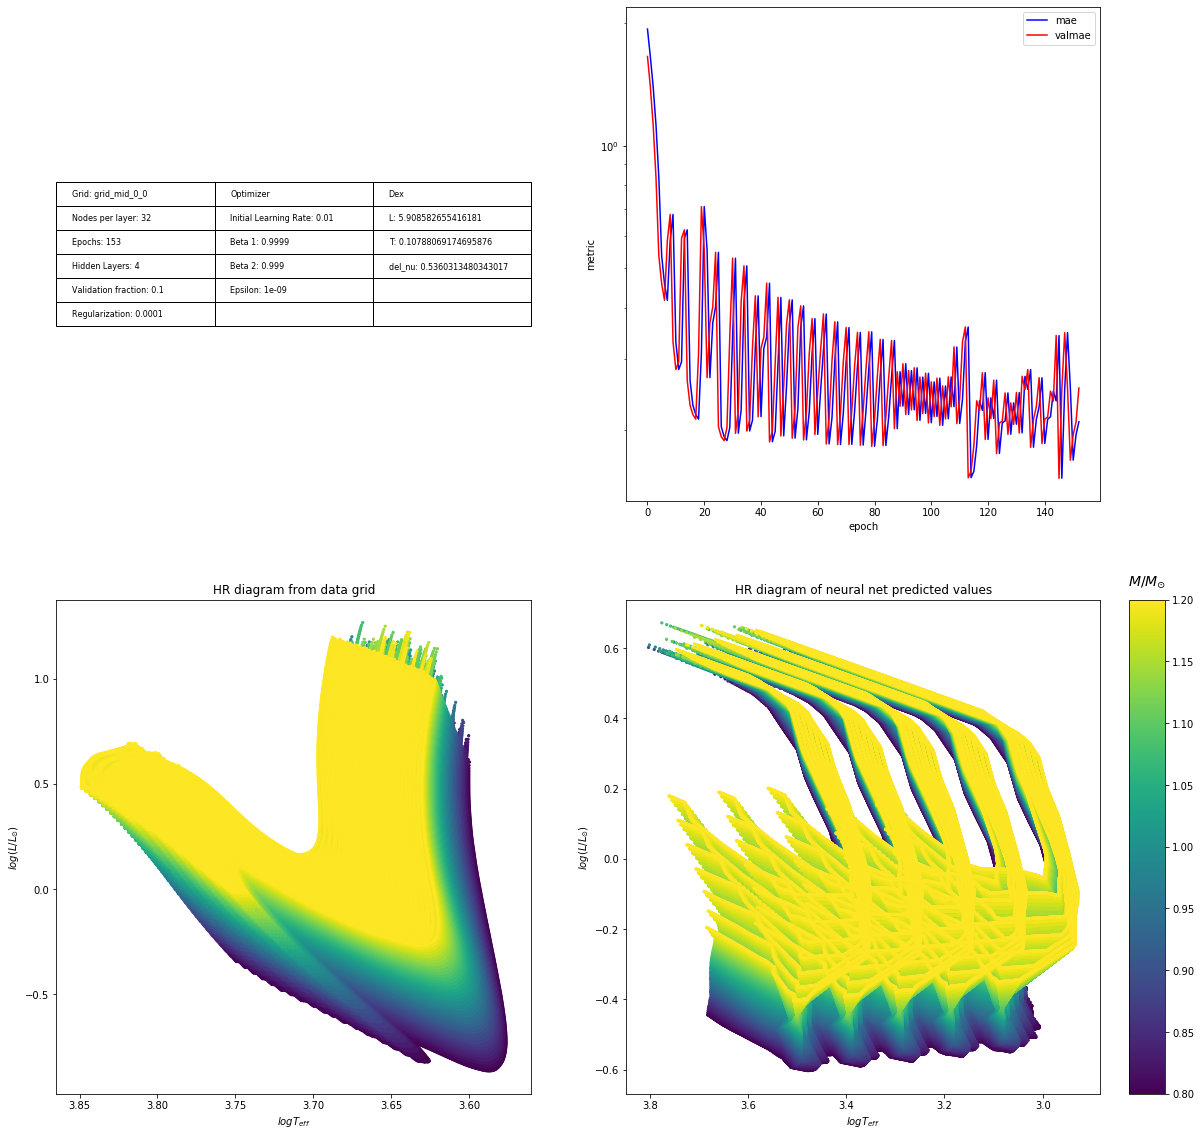

In [4]:
#where is the mid_grid file going to be?
#make sure all the preferences files are int he right place

Run_NeuralNet(file=grid_file,pref_file=pref_file,model_name=model_name,new=new)
#post_training_plot(model_name=model_name,file=grid_file,pref_file=pref_file)